In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression as ols
import statsmodels.api as sm

END_DT = '2021-01-01'


### Motivation
This notebook replicates some of the results from Ang, Hodrick, Xing, and Zhang's paper [The Cross-Section of Volatility and Expected Returns](https://www0.gsb.columbia.edu/faculty/rhodrick/crosssection.pdf). Specifically I show that stocks with high sensitivities to innovations in aggregate volatility have low average returns. This work was done under the direction of Dr. Brian Boyer, whom I work for as a research assistant, as part of our research into a decomposition of stock volatility.


### Import Data

In [2]:
#Fama French Daily
daily_french = pd.read_csv('./MKT/F-F_Research_Data_Factors_daily.csv', skiprows = 3, skipfooter=1, index_col = 0,  engine='python')
daily_french['date'] = pd.to_datetime(daily_french.index,format="%Y%m%d")
daily_french['Mkt-RF'] = daily_french['Mkt-RF']/100
daily_french['RF'] = daily_french['RF']/100
daily_french['SMB'] = daily_french['SMB']/100
daily_french['HML'] = daily_french['HML']/100

In [2]:
#Fama French Monthly
monthly_french = pd.read_csv('./MKT/F-F_Research_Data_Factors.csv', skiprows = 3, skipfooter=1, index_col = 0, engine='python')
monthly_french = monthly_french[monthly_french.index.str.lstrip().str.len() == 6]
monthly_french['date'] = pd.to_datetime(monthly_french.index,format="%Y%m")

monthly_french = monthly_french[(monthly_french['date'] > '1985-12-30') & (monthly_french['date'] < END_DT)]
monthly_french['Year_Month'] = monthly_french['date'].dt.strftime('%Y-%m')
monthly_french['Month_ID'] = pd.factorize(monthly_french['Year_Month'])[0]
monthly_french['Mkt-RF'] = monthly_french['Mkt-RF'].astype('float64')/100
monthly_french['RF'] = monthly_french['RF'].astype('float64')/100
monthly_french['SMB'] = monthly_french['SMB'].astype('float64')/100
monthly_french['HML'] = monthly_french['HML'].astype('float64')/100

monthly_french = monthly_french[monthly_french['date'] > '1999-12-31']

In [4]:
#CRSP Daily
daily_crsp = pd.read_csv('./CRSP/1986-2021_crsp.csv', low_memory=False)
daily_crsp = daily_crsp.dropna()
daily_crsp['RET'] = pd.to_numeric(daily_crsp['RET'], errors = 'coerce')
daily_crsp['date'] = pd.to_datetime(daily_crsp['date'], format="%Y%m%d")
daily_crsp['MCAP'] = daily_crsp['PRC'].abs() * daily_crsp['SHROUT']
daily_crsp = daily_crsp.drop(columns = ['SHRCD', 'PRC', 'SHROUT'])

daily_crsp = daily_crsp[(daily_crsp['date'] > '1986-01-01') & (daily_crsp['date'] < END_DT)]

In [3]:
#CRSP Monthly
monthly_crsp = pd.read_csv('./CRSP/1986-2021_monthly_crsp.csv')
monthly_crsp = monthly_crsp.dropna()
monthly_crsp['RET'] = pd.to_numeric(monthly_crsp['RET'], errors = 'coerce')
monthly_crsp['date'] = pd.to_datetime(monthly_crsp['date'], format="%Y%m%d")
monthly_crsp['PRC'] = monthly_crsp['PRC'].abs()

monthly_crsp['mcap'] = monthly_crsp['SHROUT'] * monthly_crsp['PRC']
monthly_crsp['Year_Month'] = monthly_crsp['date'].dt.strftime('%Y-%m')
monthly_crsp['Month_ID'] = pd.factorize(monthly_crsp['Year_Month'])[0]

monthly_crsp = monthly_crsp[monthly_crsp['date'] > '1999-12-31']

In [24]:
#COBE VIX
vix_old = pd.read_excel('./VIX/vxoarchive.xls',  skiprows = 2)
vix_old['Date'] = pd.to_datetime(vix_old['Date'], format="%Y%m%d")

vix_new = pd.read_csv('./VIX/vxocurrent.csv',  skiprows = 2)
vix_new.columns = vix_new.columns.str.rstrip()
vix_new['Date'] = pd.to_datetime(vix_new['Date'], format="%m/%d/%Y")

vix_df = pd.concat([vix_old, vix_new], ignore_index=True)

In [25]:
#Clean VIX data
vix_df.loc[vix_df['Close'] == '32.50  1.01', 'Close'] = '32.50'
vix_df['Close'] = vix_df['Close'].fillna(0).astype('float64')/100
vix_df['Delta_VIX'] = vix_df['Close'] - vix_df['Close'].shift(1)
vix_df['date'] = pd.to_datetime(vix_df['Date'], format="%Y%m%d")

<AxesSubplot:xlabel='date'>

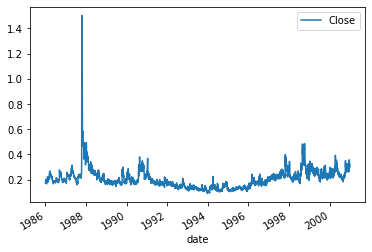

In [43]:
vix_df[vix_df.date < END_DT].plot(x='date', y='Close', xlabel='date')

Make sure our VIX data matches the papers. The graph looks idential to Figure 1 (pg 265) so we're good to go.

In [29]:
vix_df

,Date,Open,High,Low,Close,Delta_VIX,date
0,1986-01-02,17.93,18.71,17.40,0.1807,NaN,1986-01-02
1,1986-01-03,19.04,19.10,17.72,0.1796,-0.0011,1986-01-03
2,1986-01-06,17.99,18.17,17.05,0.1705,-0.0091,1986-01-06
3,1986-01-07,18.01,18.11,17.30,0.1739,0.0034,1986-01-07
4,1986-01-08,18.04,21.15,16.63,0.1997,0.0258,1986-01-08
...,...,...,...,...,...,...,...
8816,2020-12-31,21.74,22.02,20.52,0.2105,-0.0049,2020-12-31
8817,2021-01-04,22.43,27.16,21.96,0.2490,0.0385,2021-01-04
8818,2021-01-05,25.24,26.80,23.64,0.2369,-0.0121,2021-01-05
8819,2021-01-06,23.48,24.48,19.69,0.2328,-0.0041,2021-01-06


### Merge Data

In [30]:
#Add delta VIX column to CRSP daily data
df = daily_crsp[['PERMNO', 'RET', 'MCAP', 'date']].merge(daily_french.reset_index()[['date', 'Mkt-RF', 'RF']], how='left', on= 'date')
df = df.merge(vix_df[['date', 'Delta_VIX']], how = 'left', on = 'date')

In [31]:
#Code each month-year in our data set as a period
df['Year_Month'] = df['date'].dt.strftime('%Y-%m')
df['Month_ID'] = pd.factorize(df['Year_Month'])[0]
df_m = df.set_index(['Month_ID', 'PERMNO', 'date'])
df_m = df_m.drop(columns=['Year_Month'])
df = df.dropna()

In [32]:
#Filter out all assets with less than 17 trading day in a month
df_filtered = df_m.groupby(['Month_ID', 'PERMNO']).filter(lambda x: len(x) > 17)
#Calculate excess returns
df_filtered['Excess_RET'] = df_filtered['RET'] - df_filtered['RF']

In [33]:
df_filtered.sort_index()

RET          MCAP  Mkt-RF       RF  \
Month_ID PERMNO date                                                  
0        10000  1986-01-08 -0.024390  9.200000e+03 -0.0216  0.00025   
                1986-01-09  0.000000  9.200000e+03 -0.0117  0.00025   
                1986-01-10  0.000000  9.200000e+03 -0.0002  0.00025   
                1986-01-13  0.050000  9.660000e+03  0.0028  0.00025   
                1986-01-14  0.047619  1.012000e+04  0.0001  0.00025   
...                              ...           ...     ...      ...   
419      93436  2020-12-24  0.024444  6.272925e+08  0.0021  0.00000   
                2020-12-28  0.002901  6.291124e+08  0.0046  0.00000   
                2020-12-29  0.003465  6.312926e+08 -0.0040  0.00000   
                2020-12-30  0.043229  6.585827e+08  0.0027  0.00000   
                2020-12-31  0.015674  6.773402e+08  0.0039  0.00000   

                            Delta_VIX  Excess_RET  
Month_ID PERMNO date                               
0        10000  1986-01-08   0.000258   -0.024640  
                1986-01-09   0.000023   -0.000250  
                1986-01-10  -0.000175   -0.000250  
                1986-01-13   0.000035    0.049750  
                1986-01-14  -0.000074    0.047369  
...                               ...         ...  
419      93436  2020-12-24  -0.000065    0.024444  
                2020-12-28  -0.000087    0.002901  
                2020-12-29   0.000133    0.003465  
                2020-12-30   0.000008    0.043229  
                2020-12-31  -0.000049    0.015674  

[45309480 rows x 6 columns]

### Run monthly regression
Here we preform the pre-formation regression, equation 3 page 266, as follows:

$r^i_t = \beta_0 + \beta^i_{MKT} \textbf{MKT}_t + \beta^i_{\Delta VIX} \Delta \textbf{VIX}_t + \epsilon^i_t$

In [34]:
def regress_monthly(x):
    
    X = x[['Mkt-RF', 'Delta_VIX']]
    y = x['Excess_RET']
    
    reg = ols().fit(X, y)
    x['beta_VIX'] = reg.coef_[1]
    
    return x

In [35]:
df_reg = df_filtered.groupby(['Month_ID', 'PERMNO']).apply(regress_monthly)

In [ ]:
df_reg.to_csv('Regression_Full.csv')

In [36]:
df_reg

RET          MCAP  Mkt-RF       RF  \
Month_ID PERMNO date                                                  
0        10000  1986-01-08 -0.024390  9.200000e+03 -0.0216  0.00025   
                1986-01-09  0.000000  9.200000e+03 -0.0117  0.00025   
                1986-01-10  0.000000  9.200000e+03 -0.0002  0.00025   
                1986-01-13  0.050000  9.660000e+03  0.0028  0.00025   
                1986-01-14  0.047619  1.012000e+04  0.0001  0.00025   
...                              ...           ...     ...      ...   
419      93436  2020-12-24  0.024444  6.272925e+08  0.0021  0.00000   
                2020-12-28  0.002901  6.291124e+08  0.0046  0.00000   
                2020-12-29  0.003465  6.312926e+08 -0.0040  0.00000   
                2020-12-30  0.043229  6.585827e+08  0.0027  0.00000   
                2020-12-31  0.015674  6.773402e+08  0.0039  0.00000   

                            Delta_VIX  Excess_RET   beta_VIX  
Month_ID PERMNO date                                          
0        10000  1986-01-08   0.000258   -0.024640  52.342593  
                1986-01-09   0.000023   -0.000250  52.342593  
                1986-01-10  -0.000175   -0.000250  52.342593  
                1986-01-13   0.000035    0.049750  52.342593  
                1986-01-14  -0.000074    0.047369  52.342593  
...                               ...         ...        ...  
419      93436  2020-12-24  -0.000065    0.024444  78.006619  
                2020-12-28  -0.000087    0.002901  78.006619  
                2020-12-29   0.000133    0.003465  78.006619  
                2020-12-30   0.000008    0.043229  78.006619  
                2020-12-31  -0.000049    0.015674  78.006619  

[45309480 rows x 7 columns]

In [4]:
df_reg = pd.read_csv('Regression_Full.csv')

### Construct Monthly Portfolio Returns
Now we construct our monthly portfolios based on their exposure to the VIX. As the paper specifies we use quintiles and weight returns based on their share of total porfolio market cap.

In [5]:
df_monthly = df_reg[df_reg.date > '1999-12-31'].reset_index().drop(columns=['RET', 'Mkt-RF'])
df_monthly['Quintile'] = df_monthly.groupby('Month_ID')['beta_VIX'].transform(lambda x: pd.qcut(x, 5, labels=range(1,6)))

In [6]:
sorted_permnos = df_monthly[['Month_ID', 'PERMNO', 'beta_VIX', 'Quintile', 'date']].drop_duplicates()
prev = sorted_permnos.copy()
prev['Month_ID'] = prev['Month_ID'] + 1
sorted_permnos = sorted_permnos.merge(prev, how='left', on=['PERMNO', 'Month_ID'], suffixes=(None, '_Prev'))

In [ ]:
monthly_ports = monthly_crsp.merge(sorted_permnos, how='left', on=['Month_ID', 'PERMNO'], suffixes=("_crsp", ""))
monthly_ports = monthly_ports.merge(monthly_french[['Month_ID', 'Mkt-RF', 'SMB', 'HML', 'RF']], how='left', on='Month_ID')
monthly_ports['beta_VIX_Prev'] = monthly_ports['beta_VIX_Prev']/100
monthly_ports = monthly_ports[(monthly_ports['date'] > '1986-01-01')&(monthly_ports['date'] < '2021-01-01')]
monthly_ports = monthly_ports.drop(columns=['date_Prev', 'PRC', 'SHROUT', 'date_crsp'])

In [14]:
monthly_ports['beta_VIX_Prev'] = monthly_ports['beta_VIX_Prev']/100
monthly_ports = monthly_ports[(monthly_ports['date'] > '1986-01-01')&(monthly_ports['date'] < '2021-01-01')]
monthly_ports = monthly_ports.drop(columns=['date_Prev', 'PRC', 'SHROUT', 'date_crsp'])

In [9]:
prev = monthly_ports[['PERMNO', 'Month_ID', 'mcap', 'Mkt-RF', 'SMB', 'HML', 'RF']]
prev['Month_ID'] = prev['Month_ID'] + 1
monthly_ports = monthly_ports.merge(prev, how='left', on=['PERMNO', 'Month_ID'], suffixes=(None, '_Prev')).dropna()

In [12]:
monthly_ports = monthly_ports.dropna()

In [66]:
#Calculate weighted returns
monthly_ports = monthly_ports.join(monthly_ports.groupby(['Month_ID', 'Quintile_Prev'])['mcap_Prev'].sum(), on=['Month_ID', 'Quintile_Prev'], rsuffix='_Total')
monthly_ports['Weight'] = monthly_ports['mcap_Prev'] / monthly_ports['mcap_Prev_Total']

monthly_ports['Weighted_RET'] = monthly_ports['Weight'] * monthly_ports['RET']
monthly_ports['Weighted_beta_VIX'] = monthly_ports['Weight'] * monthly_ports['beta_VIX']
monthly_ports['Weighted_beta_VIX_Prev'] = monthly_ports['Weight'] * monthly_ports['beta_VIX_Prev']

monthly_ports = monthly_ports.groupby(['Month_ID', 'Quintile_Prev', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mkt-RF_Prev', 'SMB_Prev', 'HML_Prev', 'RF_Prev']).agg({'Weighted_RET': 'sum', 'Weighted_beta_VIX': 'sum',  'Weighted_beta_VIX_Prev': 'sum'}).reset_index()
monthly_ports['Excess_Ret'] = monthly_ports['Weighted_RET'] - monthly_ports['RF']


In [67]:
monthly_ports

,Month_ID,Quintile_Prev,Mkt-RF,SMB,HML,RF,Mkt-RF_Prev,SMB_Prev,HML_Prev,RF_Prev,Weighted_RET,Weighted_beta_VIX,Weighted_beta_VIX_Prev,Excess_Ret
0,1,1.0,0.0713,-0.0062,-0.0085,0.0053,0.0065,0.0122,0.0052,0.0056,0.071523,-3.471863,-0.922214,0.066223
1,1,2.0,0.0713,-0.0062,-0.0085,0.0053,0.0065,0.0122,0.0052,0.0056,0.068524,-0.576236,-0.276341,0.063224
2,1,3.0,0.0713,-0.0062,-0.0085,0.0053,0.0065,0.0122,0.0052,0.0056,0.073933,7.904574,0.002105,0.068633
3,1,4.0,0.0713,-0.0062,-0.0085,0.0053,0.0065,0.0122,0.0052,0.0056,0.082202,-2.440018,0.262309,0.076902
4,1,5.0,0.0713,-0.0062,-0.0085,0.0053,0.0065,0.0122,0.0052,0.0056,0.091972,-3.233451,0.783369,0.086672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,419,1.0,0.0463,0.0481,-0.0136,0.0001,0.1247,0.0548,0.0211,0.0001,0.033135,20.588838,-0.788172,0.033035
2081,419,2.0,0.0463,0.0481,-0.0136,0.0001,0.1247,0.0548,0.0211,0.0001,0.039001,-1.549291,-0.165257,0.038901
2082,419,3.0,0.0463,0.0481,-0.0136,0.0001,0.1247,0.0548,0.0211,0.0001,0.042952,-18.147610,0.362870,0.042852
2083,419,4.0,0.0463,0.0481,-0.0136,0.0001,0.1247,0.0548,0.0211,0.0001,0.082470,-14.997689,0.912939,0.082370


In [55]:
#Grab table statsitics and scale them the way they are reported in the paper
table_1 = monthly_ports.groupby('Quintile_Prev').mean()[['Weighted_RET', 'Weighted_beta_VIX_Prev', 'Weighted_beta_VIX']]
table_1['Weighted_RET'] = table_1['Weighted_RET']*100
table_1['Weighted_beta_VIX'] = table_1['Weighted_beta_VIX']*100
table_1

,Weighted_RET,Weighted_beta_VIX_Prev,Weighted_beta_VIX
Quintile_Prev,,,
1.0,1.665300,-1.329622,-303.069476
2.0,1.380752,-0.427921,-291.615943
3.0,1.291133,0.031435,-8.609909
4.0,1.226198,0.500287,245.590800
5.0,0.581610,1.471361,644.783893


These are looking almost identical to the numbers presented in Table 1 of the paper. Now we'll calculate alphas.

### Calculate Alphas for Portfolios

The alphas in the paper are calculated using two diffent regressions. The first is a simple CAPM regression specified as $r^i_t = \alpha^i + \beta^i_{MKT} 
\textbf{MKT}_{t} + \epsilon^i_t$

The second is a FFM regression specified as $r^i_t = \alpha^i + \beta^i_{MKT} 
\textbf{MKT}_{t} + \beta^i_{SMB} \textbf{SMB}_{t} + \beta^i_{HML} \textbf{HML}_{t} +\epsilon^i_t$

In [56]:
def get_alphas(x):
    
    X = x[['Mkt-RF', 'SMB', 'HML']]
    y = (x['Excess_Ret'])*100
    
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    
    x['FF3_alpha'] = results.params['const']
    x['t-stat_FF3'] = results.tvalues['const']
    
    X = x[['Mkt-RF']]
    y = (x['Excess_Ret'])*100
    
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    
    x['CAPM_alpha'] = results.params['const']
    x['t-stat_CAPM'] = results.tvalues['const']
    
    return x

In [57]:
port_returns = monthly_ports.dropna().groupby(['Quintile_Prev']).apply(get_alphas)

In [58]:
port_returns[['Quintile_Prev', 'CAPM_alpha', 'FF3_alpha', 't-stat_CAPM', 't-stat_FF3']].drop_duplicates()

,Quintile_Prev,CAPM_alpha,FF3_alpha,t-stat_CAPM,t-stat_FF3
0,1.0,0.270767,0.308546,1.615741,1.810433
1,2.0,0.153801,0.063881,1.469771,0.684176
2,3.0,0.049489,-0.038956,0.617897,-0.534781
3,4.0,-0.079874,-0.076159,-0.874452,-0.836113
4,5.0,-0.914830,-0.554910,-3.813393,-3.269090


We can see here our alphas and test statistics are also almost identical to Table 1 of the paper.